In [1]:
from random import randint
import heapq
import sys
sys.path.insert(1, 'util/')
import disjointset as ds
import utilities
import graph_algorithms as ga
import numpy as np
from collections import Counter

In [2]:
def leer_csv(ubicacion, **kwargs):
    with open(ubicacion, 'r') as archivo:
        h = []
        separador = kwargs['sep'] if 'sep' in kwargs else ','
        datos = {}
        if 'header' in kwargs and kwargs['header'] == False:
            encabezado = archivo.readline().rstrip('\n')
            encabezado = [chr(ord('A') + i) for i in range(len(encabezado.split(separador)))]
            datos = dict(zip(encabezado, [[] for _ in range(len(encabezado))]))
        else:
            h = archivo.readline().rstrip('\n')
            encabezado = h.split(separador)
            datos = dict(zip(encabezado, [[] for _ in range(len(encabezado))]))
        entero = 'integer' not in kwargs or ('integer' in kwargs and kwargs['integer']) == True
        for indice, linea in enumerate(archivo):
            linea = linea.rstrip('\n')
            fila = linea.split(separador)
            for celda, columna  in zip(fila, list(datos.keys())):
                if celda.isnumeric() and entero == True:
                    datos[columna].append(int(celda))
                else:
                    datos[columna].append(celda)
        return datos 

### Lectura de datos
Los datos se leeran en 2 diccionarios `almacenes` y `puntos` que estan definidos como: `{'x': [], 'y': []}` en donde se almacenaran los puntos.

In [3]:
distancia = lambda p1, p2: abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])         
almacenes = leer_csv('../DataSet/Almacenes.csv', header=True, integer=True) 
puntos = leer_csv('../DataSet/PuntosEntrega.csv', header=True, integer=True) 

### Almacenes
Los almacenes tendran una cantidad de paquetes aleatoria.

In [4]:
cantidad_de_paquetes = len(puntos['x'])
paquetes_por_almacen = [0] * len(almacenes['x'][:20])
for _ in range(20):
    paquetes_por_almacen[randint(0, 19)] += 1
print(paquetes_por_almacen)

[2, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 2, 3, 1, 2, 1]


### Construccion del grafo
Teniendo $n$ puntos de entrega, el grafo sera una lista de $n$ listas, en donde el indice de la lista representa un punto de entrega y dentro de la lista existen $m$ puntos de entrega que son los $m$ puntos mas cercanos al punto que representa el indice. \
$O(n^2)$

In [5]:
def a_punto(pos):
        return [puntos['x'][pos], puntos['y'][pos]]

def a_grafo(pts, adj=10):
    vs = [ [] for _ in range(len(pts['x'])) ]
    for i in range(len(vs)):
        # Conseguir los N puntos mas cercanos
        cercanos = heapq.nsmallest(adj, enumerate(list(zip(pts['x'], pts['y']))), key=lambda x: distancia(x[1], a_punto(i)))
        # Iterar por cada uno y pushear la distancia (peso) y su indice
        for indice, nodo in cercanos:
            peso = distancia(nodo, a_punto(i))
            if peso == 0: continue
            vs[i].append((indice, peso))
    return vs

El grafo se generará con los $5$ nodos mas cercanos a cada nodo.

In [6]:
grafo = a_grafo({'x':puntos['x'][:20], 'y':puntos['y'][:20] }, 5)

### El algoritmo.
Se utilizó Kruskal: $O(E \log V)$

In [7]:
import heapq as hq
def kruskal(G):
    n = len(G)
    edges = []
    for u in range(n):
        for v, w in G[u]:
            hq.heappush(edges, (w, u, v))

    uf = ds.DisjointSet(n)

    T = []
    while edges and n > 0:
        w, u, v = hq.heappop(edges)
        if not uf.sameset(u, v):
            uf.union(u, v)
            T.append((u, v, w))
            n -= 1

    return T

### crear_ruta Re implementada y explicada mas abajo

In [8]:
def crear_ruta(gr):
    T = kruskal(gr)
    n = len(gr)
    Gp = [[] for _ in range(n)]
    for u, v, _ in T:
        Gp[u].append(v)
        Gp[v].append(u)
    ruta = ga.bfs(Gp, 0)
    ruta = list([*Counter(ruta)])
    acopy = almacenes.copy()
    almacen_actual = np.argmax(paquetes_por_almacen)
    paquetes = paquetes_por_almacen[almacen_actual]
    get_punto = lambda indice: (puntos['x'][indice], puntos['y'][indice])
    print(f'Paquetes: {paquetes}')
    for i in range(1, len(ruta)):
        print('Punto actual:', ruta[i])
        if paquetes <= 0:          
            enum = enumerate(zip(acopy['x'][:20], acopy['y'][:20]))
            almacen_actual = min(enum, key=lambda x: distancia(x[1], get_punto(ruta[i])))
            print(almacen_actual)
            paquetes = paquetes_por_almacen[almacen_actual[0]]
            print(f'Paquetes: {paquetes}')
        paquetes -= 1
    return ruta

### Representación gráfica
Para probar el algoritmo se utilizaron 20 nodos.

Paquetes: 3
Punto actual: 2
Punto actual: 16
Punto actual: 6
Punto actual: 7
(13, (749, 362))
Paquetes: 1
Punto actual: 8
(19, (318, 220))
Paquetes: 1
Punto actual: 10
(0, (672, 301))
Paquetes: 2
Punto actual: 17
Punto actual: 19
(12, (435, 485))
Paquetes: 0
Punto actual: 0
(8, (730, 653))
Paquetes: 0
Punto actual: 13
(18, (308, 869))
Paquetes: 2
Punto actual: 3
Punto actual: 9
(7, (275, 559))
Paquetes: 1
Punto actual: 12
(18, (308, 869))
Paquetes: 2
Punto actual: 11
Punto actual: 1
(16, (723, 873))
Paquetes: 3
Punto actual: 4


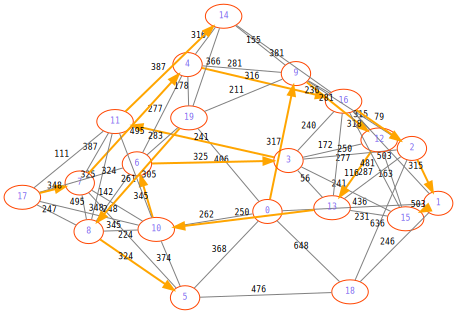

In [9]:
utilities.adjlShow(grafo, weighted=True, path=crear_ruta(grafo))

### Ruta con todos los nodos

In [10]:
grafo = a_grafo({'x':puntos['x'][:], 'y':puntos['y'][:] }, 5)

In [11]:
cantidad_de_paquetes = len(puntos['x'])
paquetes_por_almacen = [0] * len(almacenes['x'][:])
for _ in range(cantidad_de_paquetes):
    paquetes_por_almacen[randint(0, len(paquetes_por_almacen)-1)] += 1
print(paquetes_por_almacen)

[49, 61, 38, 47, 47, 46, 46, 47, 54, 63, 52, 55, 38, 57, 53, 44, 35, 42, 52, 37, 51, 30, 51, 47, 52, 53, 55, 54, 54, 48, 51, 51, 37, 53, 37, 50, 53, 41, 59, 54, 63, 47, 52, 47, 55, 55, 48, 60, 46, 48, 48, 54, 47, 49, 45, 55, 54, 53, 47, 49, 59, 48, 47, 49, 71, 49, 45, 37, 51, 45, 54, 49, 53, 49, 39, 61, 53, 54, 50, 47, 53, 46, 64, 58, 56, 53, 46, 65, 50, 45, 53, 50, 46, 42, 64, 46, 59, 45, 44, 39]


### crear_ruta
Crear ruta, recorre el camino que nos da kruskal en base a los puntos de entrega.
A dicha ruta, se le agrega los almacenes por los que debe pasar.
El algoritmo parte del `almacen` que tenga mas paquetes. Luego, entregara todos los `paquetes` en los `puntos de entrega` que se encuentren en la ruta, y a partir de ahi buscara el siguiente `almacen` mas cercano y entregara todos sus paquetes siguiendo la ruta.

In [12]:
def crear_ruta(gr):
    T = kruskal(gr)
    n = len(gr)
    Gp = [[] for _ in range(n)]
    for u, v, _ in T:
        Gp[u].append(v)
        Gp[v].append(u)
    ruta = ga.bfs(Gp, 0)
    ruta = list([*Counter(ruta)])
    acopy = almacenes.copy()
    almacen_actual = np.argmax(paquetes_por_almacen)
    paquetes = paquetes_por_almacen[almacen_actual]
    get_punto = lambda indice: (puntos['x'][indice], puntos['y'][indice])
    print(f'Paquetes: {paquetes}')
    for i in range(1, len(ruta)):
        print('Punto actual:', ruta[i])
        if paquetes <= 0:          
            enum = enumerate(zip(acopy['x'][:], acopy['y'][:]))
            almacen_actual = min(enum, key=lambda x: distancia(x[1], get_punto(ruta[i])))
            print(almacen_actual)
            paquetes = paquetes_por_almacen[almacen_actual[0]]
            print(f'Paquetes: {paquetes}')
        paquetes -= 1
    return ruta

Al estar trabajando con muchos nodos, se hace imposible entender el grafo de arriba.
El output explica el orden de los almacenes que se recorrren, y por cada almacen, se imprimen la cantidad de paquetes que tiene cada almacen, en el orden que se van entregando.

In [13]:
ruta = crear_ruta(grafo)

Paquetes: 71
Punto actual: 3274
Punto actual: 2749
Punto actual: 3224
Punto actual: 2208
Punto actual: 2724
Punto actual: 1669
Punto actual: 1985
Punto actual: 1248
Punto actual: 3667
Punto actual: 4084
Punto actual: 253
Punto actual: 3603
Punto actual: 1191
Punto actual: 3840
Punto actual: 3744
Punto actual: 620
Punto actual: 440
Punto actual: 444
Punto actual: 3895
Punto actual: 920
Punto actual: 3730
Punto actual: 1374
Punto actual: 2324
Punto actual: 3602
Punto actual: 1783
Punto actual: 3690
Punto actual: 3849
Punto actual: 1564
Punto actual: 3506
Punto actual: 1666
Punto actual: 2935
Punto actual: 631
Punto actual: 4181
Punto actual: 2002
Punto actual: 4353
Punto actual: 1396
Punto actual: 173
Punto actual: 3974
Punto actual: 1173
Punto actual: 1522
Punto actual: 3932
Punto actual: 1673
Punto actual: 3153
Punto actual: 2740
Punto actual: 2344
Punto actual: 3656
Punto actual: 1888
Punto actual: 2576
Punto actual: 1502
Punto actual: 4457
Punto actual: 4610
Punto actual: 4832
Punto 

Punto actual: 2025
Punto actual: 2023
Punto actual: 617
Punto actual: 1037
Punto actual: 977
Punto actual: 4110
Punto actual: 78
Punto actual: 4215
(84, (163, 749))
Paquetes: 56
Punto actual: 2879
Punto actual: 1485
Punto actual: 4478
Punto actual: 640
Punto actual: 1260
Punto actual: 1331
Punto actual: 1569
Punto actual: 4864
Punto actual: 1621
Punto actual: 3259
Punto actual: 852
Punto actual: 4506
Punto actual: 4807
Punto actual: 2024
Punto actual: 2943
Punto actual: 409
Punto actual: 2049
Punto actual: 1175
Punto actual: 4116
Punto actual: 2893
Punto actual: 866
Punto actual: 1165
Punto actual: 655
Punto actual: 4310
Punto actual: 540
Punto actual: 4926
Punto actual: 645
Punto actual: 4855
Punto actual: 3326
Punto actual: 3292
Punto actual: 665
Punto actual: 2660
Punto actual: 3336
Punto actual: 2162
Punto actual: 3969
Punto actual: 4711
Punto actual: 2294
Punto actual: 13
Punto actual: 397
Punto actual: 875
Punto actual: 667
Punto actual: 81
Punto actual: 3273
Punto actual: 20
Pun

Punto actual: 1638
Punto actual: 1933
Punto actual: 3087
Punto actual: 2309
Punto actual: 707
Punto actual: 4753
Punto actual: 1267
Punto actual: 3811
Punto actual: 2982
Punto actual: 1369
Punto actual: 1161
Punto actual: 4984
Punto actual: 4919
Punto actual: 4830
Punto actual: 3210
Punto actual: 3324
Punto actual: 2609
Punto actual: 4464
Punto actual: 4812
Punto actual: 3447
Punto actual: 2356
Punto actual: 3544
Punto actual: 3904
Punto actual: 2764
Punto actual: 3534
Punto actual: 3066
Punto actual: 2522
Punto actual: 4858
Punto actual: 2222
Punto actual: 961
Punto actual: 2511
Punto actual: 127
Punto actual: 1623
Punto actual: 679
Punto actual: 1262
Punto actual: 2849
Punto actual: 1328
Punto actual: 4455
(7, (275, 559))
Paquetes: 47
Punto actual: 4341
Punto actual: 23
Punto actual: 4231
Punto actual: 1452
Punto actual: 4364
Punto actual: 1662
Punto actual: 4887
Punto actual: 3548
Punto actual: 4935
Punto actual: 2794
Punto actual: 3057
Punto actual: 1150
Punto actual: 3285
Punto ac

Punto actual: 3638
Punto actual: 2665
Punto actual: 3173
Punto actual: 1981
Punto actual: 1337
Punto actual: 1221
Punto actual: 3155
Punto actual: 3842
Punto actual: 4601
Punto actual: 3924
Punto actual: 4625
Punto actual: 4443
Punto actual: 3671
Punto actual: 4040
Punto actual: 3934
Punto actual: 4319
Punto actual: 2771
Punto actual: 4424
Punto actual: 571
Punto actual: 4802
Punto actual: 4939
Punto actual: 2207
Punto actual: 4989
Punto actual: 1886
Punto actual: 416
Punto actual: 3198
Punto actual: 151
Punto actual: 262
Punto actual: 1172
Punto actual: 2579
Punto actual: 744
Punto actual: 1603
Punto actual: 1565
Punto actual: 1367
Punto actual: 2707
Punto actual: 778
Punto actual: 525
Punto actual: 2454
Punto actual: 2581
Punto actual: 3526
Punto actual: 1011
Punto actual: 4086
Punto actual: 1921
Punto actual: 4712
Punto actual: 867
Punto actual: 1713
Punto actual: 4088
Punto actual: 574
Punto actual: 3537
Punto actual: 2374
Punto actual: 1224
(66, (807, 73))
Paquetes: 45
Punto actua

Punto actual: 1186
Punto actual: 2737
Punto actual: 3764
Punto actual: 3129
Punto actual: 2887
Punto actual: 4923
Punto actual: 118
Punto actual: 203
Punto actual: 3386
Punto actual: 3639
Punto actual: 1645
Punto actual: 390
Punto actual: 891
Punto actual: 1539
Punto actual: 188
Punto actual: 4727
Punto actual: 3812
Punto actual: 1843
Punto actual: 1506
Punto actual: 2442
Punto actual: 4598
Punto actual: 2211
Punto actual: 4085
Punto actual: 702
Punto actual: 4549
(62, (895, 932))
Paquetes: 47
Punto actual: 703
Punto actual: 2895
Punto actual: 1847
Punto actual: 1306
Punto actual: 3605
Punto actual: 779
Punto actual: 1628
Punto actual: 1000
Punto actual: 322
Punto actual: 2600
Punto actual: 3277
Punto actual: 530
Punto actual: 638
Punto actual: 813
Punto actual: 1231
Punto actual: 639
Punto actual: 4452
Punto actual: 766
Punto actual: 1003
Punto actual: 2022
Punto actual: 3657
Punto actual: 1198
Punto actual: 3235
Punto actual: 243
Punto actual: 3089
Punto actual: 4281
Punto actual: 34